In [ ]:
learner = load_learner('/content/',test=data_class)

In [ ]:
(learn_c.data.__class__)

In [1]:
import pickle
import numpy as np
import re
import json

In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/wordemb_dataset.csv')
df.head()

,instance,prep,geo-feature,placename,sum,or,label exp1,label exp 2,label exp 3,label exp 4
0,any project searching for a shared female ide...,for,1,0,1,1,0.0,0.0,0.0,0.0
1,searching a shared female identity in the wor...,in,1,0,1,1,0.0,0.0,0.0,0.0
2,misleading yet the shared endeavour by women ...,by,1,0,1,1,0.0,0.0,0.0,0.0
3,shared endeavour women to succeed in their ch...,in,1,0,1,1,0.0,0.0,0.0,0.0
4,succeed their chosen field and on their own t...,on,1,0,1,1,0.0,0.0,0.0,0.0


In [3]:
test_df=df[:1882].copy()

In [ ]:
np.set_printoptions(precision=4, suppress=True)

In [ ]:
!wget http://files.fast.ai/models/glove_50_glove_100.tgz 

In [ ]:
!tar xvzf glove_50_glove_100.tgz

In [ ]:
vecs = np.load("glove_vectors_100d.npy")
vecs50 = np.load("glove_vectors_50d.npy")

In [ ]:
with open('words.txt') as f:
    content = f.readlines()
words = [x.strip() for x in content]

In [ ]:
import json
wordidx = json.load(open('wordsidx.txt'))

In [ ]:
# for i in list(df['instance']):
#   print(i)

In [ ]:

#X = np.array([wordidx[word] for word in list(df['instance']))
X=[]
for i in (list(df['instance'])):
  # print(i)
  sentence_vector=[]
  try:
    for word in i.split(' '):
      if word == '':
        continue
      #print(word)
      try:
        sentence_vector.append(wordidx[word])
      except:
        pass
  except:
    pass
  X.append((sentence_vector))
# X=np.array(X)
# X.shape
type(X),len(X)

In [ ]:
(X[0])

In [ ]:
words[0]

In [ ]:
#wordidx[0]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,(list(df['label exp 3'])),test_size=0.1)

In [ ]:
type(X_test),type(X_train),type(y_train),type(y_test)

In [ ]:
y_train[0]

In [ ]:
', '.join(map(str, X_train[0]))

In [ ]:
idx=wordidx
idx

In [ ]:
idx2word = {v: k for k, v in idx.items()}

In [ ]:
idx2word[8206]

In [ ]:
' '.join([idx2word[o] for o in X_train[0]])

In [ ]:
type(X_train[0])

In [ ]:
vocab_size = 5000
# l1=[]
# for s in X_train:
#   for i in s:
#     if i<vocab_size-1:
#       # print('ping')
#       l1.append(i)
#     else:
#       # print('ping')
#       l1.append(vocab_size-1)
# # trn

# l2=[]
# for p in X_test:
#   for j in p:
#     if j<vocab_size-1:
#       # print('ping')
#       l2.append(j)
#     else:
#       # print('ping')
#       l2.append(vocab_size-1)

# trn=[np.array(l1)]
# test=[np.array(l2)]
trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in (X_train)]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in (X_test)]

In [ ]:
lens = np.array([len(instance) for instance in trn])

In [ ]:
(lens.max(), lens.min(), lens.mean())

In [ ]:
from keras.preprocessing import sequence
seq_len = 50
try:
  trn = sequence.pad_sequences(X_train, maxlen=seq_len, value=0)
  test = sequence.pad_sequences(X_test, maxlen=seq_len, value=0)
except:
  pass

In [ ]:
len(trn),trn[0]

In [ ]:
trn.shape,test.shape

In [ ]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.optimizers import Adam

In [ ]:
conv1 = Sequential([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.4),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

In [ ]:
conv1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
conv1.fit(trn, y_train, validation_data=(test, y_test), nb_epoch=4, batch_size=64)

In [ ]:
conv1.optimizer.lr=1e-4

In [ ]:
conv1.fit(trn, y_train, validation_data=(test, y_test), nb_epoch=4, batch_size=64)

In [ ]:
def create_emb():
    n_fact = vecs50.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = wordidx[word]
            emb[i] = vecs50[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = np.random.normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = np.random.normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [ ]:
emb = create_emb()

In [ ]:
emb.shape

In [ ]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.4, weights=[emb]),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [ ]:
model.fit(trn, y_train, validation_data=(test, y_test), nb_epoch=4, batch_size=64)


# Transfer learning my approach

## Fine Tune language model

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.text import *
from scipy.spatial.distance import cosine as dist

In [5]:
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/wordemb_dataset.csv')

In [6]:
df.head()

,instance,prep,geo-feature,placename,sum,or,label exp1,label exp 2,label exp 3,label exp 4
0,any project searching for a shared female ide...,for,1,0,1,1,0.0,0.0,0.0,0.0
1,searching a shared female identity in the wor...,in,1,0,1,1,0.0,0.0,0.0,0.0
2,misleading yet the shared endeavour by women ...,by,1,0,1,1,0.0,0.0,0.0,0.0
3,shared endeavour women to succeed in their ch...,in,1,0,1,1,0.0,0.0,0.0,0.0
4,succeed their chosen field and on their own t...,on,1,0,1,1,0.0,0.0,0.0,0.0


In [8]:
# remove 'na' fields
df = df[df['instance'].notna()]
df = df[df['label exp 2'].notna()]

In [9]:
# splitting into train test sets
test_df=df[16934:].copy()
train_df=df[:16934].copy()
len(test_df),len(train_df)

(1882, 16934)

In [10]:
from fastai.text import * 
# after tokenisation
data_lm = (TextList.from_df(df, cols='instance')
                .split_by_rand_pct(0.1)
                .label_for_lm()  
                .databunch(bs=48))
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,xxunk gives the following xxunk for each one xxbos may have come off worst in some scuffle over a doe xxbos come off worst some scuffle over a doe and taken it xxbos to the xxunk barbecue for sandra s birthday xxbos it was very xxunk of me xxbos filled wonder at the sound of the bazouki xxbos filled wonder the sound of the bazouki as jacques vassal xxbos wonder
1,th and which with all the houses buildings barns xxbos shillings a year and that another part was a new xxbos new xxunk or house built at southwell worth shillings a xxbos xxunk to the manor was worth shillings a year and xxbos am take off was followed by an xxunk flight and arrival xxbos an xxunk flight and arrival from a northerly direction at newbury xxbos and arrival a
2,day in xxbos pyramids giza xxunk their day in a habit not unlike the xxbos their day a habit not unlike the great british tea break xxbos a second later he was in the doorway glancing from one xxbos he was the doorway glancing from one to the other in xxbos glancing one to the other in concern xxbos a series of studies by the research group xxbos a series
3,case trevor lee advertisement manager with the northern echo said xxbos said we were asked by officers of darlington trading standards xxbos we were asked officers of darlington trading standards to produce xxbos trading standards to produce evidence of a mistake or otherwise xxbos after the expulsion of the jesuits xxbos the expulsion of the jesuits from portugal in xxbos the expulsion the jesuits from portugal in the building xxbos
4,is in xxbos death his own life is in xxunk xxbos and xxunk knew better than to argue with him when xxbos xxunk knew better to argue with him when he used that xxbos argue him when he used that particular tone of voice xxbos when he used particular tone of voice xxbos she had wanted to xxunk at him and who was to xxbos and who was to blame


In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5).to_fp16()

drop_mult , a hyper-parameter ,used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


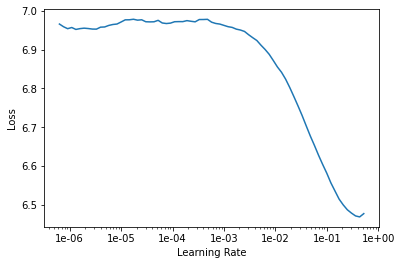

In [15]:
learn.recorder.plot(skip_end=15)

Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. Now look at the plot of learning rate against loss and determine the lowest point (around 1e-1 for the plot below) and go back by one magnitude and choose that as a learning rate (something around 1e-2).

In [16]:
#define batch size and learning rate
bs=48
lr = 2e-02
lr *= bs/20

In [18]:
# fit the classifier for one cycle
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.580949,4.972424,0.196875,00:26


In [19]:
# unfreeze all layers and then train some more
learn.unfreeze()
learn.fit_one_cycle(1, lr/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.667150,4.642206,0.231399,00:32


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.

In [20]:
# save the encoder and vocab
learn.save('fine_tuned_10')
learn.save_encoder('fine_tuned_enc_10')

## Classification Phase

In [22]:
# define dataset for classification 
data_clas = (TextList.from_df(train_df, cols=['instance'], vocab=data_lm.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df(cols= 'label exp 2')
             .databunch(bs=48))

data_clas.show_batch()

text,target
xxbos & c which has been washed down and in which xxunk timber,1.0
xxbos i am writing to you about the case of i m xxunk,0.0
xxbos the lad darted the room like a fleeing hare and vanished,1.0
xxbos xxunk which xxunk had xxunk from his own soul though he,0.0
xxbos and his wife xxunk daughter of thomas xxunk of xxunk lincolnshire,0.0


In [21]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [23]:
#initialising classifier
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy]).to_fp16()
learn_c.load_encoder('fine_tuned_enc_10')
learn_c.freeze()

In [24]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


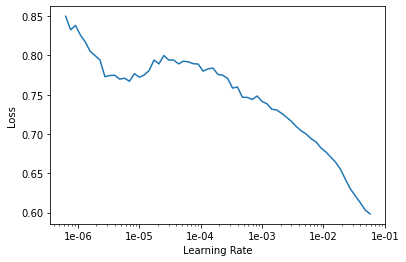

In [25]:
learn_c.recorder.plot(skip_end=15)

In [26]:
lr=2e-2

In [27]:
learn_c.fit_one_cycle(3,lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.179184,0.139875,0.558771,00:11
1,0.161983,0.137049,0.558771,00:11
2,0.155700,0.132537,0.558771,00:11


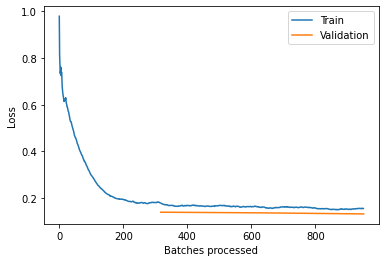

In [28]:
learn_c.recorder.plot_losses()

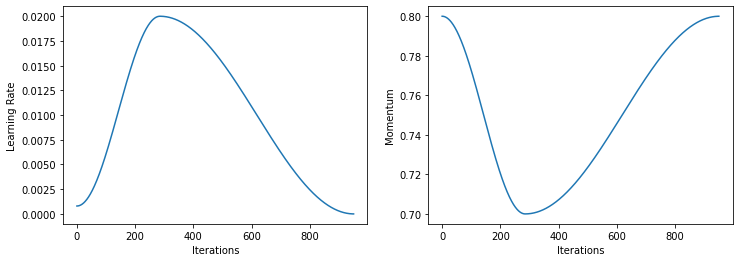

In [29]:
learn_c.recorder.plot_lr(show_moms=True)

In [30]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.142500,0.117450,0.558771,00:38


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.

### Notes

The loss curve seems going down smoothly (not in this case) and has not reached saturation point yet. fastai calculates the exponentially weighted moving average of the losses thus makes it easier to read these charts [by making the curve smoother] at the same time it might be a batch or two behind where they should be.

When we call fit_one_cycle, we are actually passing in a maximum learning rate. The left side plot shows learning rate change vs the batches. The learning starts slow and it increases about half the time and then it decreases about half the time. As you get close to the final answer you need to anneal your learning rate to hone in on it. The motivation behind this is that during the middle of learning when learning rate is higher, the learning rate works as regularization method and keep network from over-fitting. This helps the network to avoid steep areas of loss and land better flatter minima. Please refer to this paper by Leslie smith which talks in great detail about neural network hyper-parameter tuning and you can find most of these ideas implemented in fastai.

If the training loss is still higher than the validation loss then we are not over-fitting yet

Since get_preds gets predictions on all the data in the ds_type dataset, here the number of predictions will be equal to the number of data in the validation dataset.

Discriminative learning rates: Applying different learning rate to layers as you go from layer to layer. When fitting a model you can pass a list of learning rates which will apply a different rate to each layer group. When working with a Learner on which you've called split, you can set hyper-parameters in four ways:

* param = [val1, val2 ..., valn] (n = number of layer groups)
* param = val
* param = slice(start,end)
* param = slice(end)

If we chose to set it in way 1, we must specify a number of values exactly equal to the number of layer groups. If we chose to set it in way 2, the chosen value will be repeated for all layer groups. If you pass slice(start,end) then the first group's learning rate is start, the last is end, and the remaining are evenly spaced.
If you pass just slice(end) then the last group's learning rate is end, and all the other groups are end/10. For instance (for our learner that has 3 layer groups):

The bottom of the slice and the top of the slice is the difference between how quickly the lowest layer of the model learns versus the highest layer of the model learns. As you go from layer to layer, we decrease the learning rate. The lowest levels are given smaller learning rates so as not to disturb the weights much.

The first two elements of the tuple are, respectively, the predicted class and label. Label here is essentially an internal representation of each class, since class name is a string and cannot be used in computation. To check what each label corresponds to, run:

In [48]:
y_true=list(test_df['label exp 2'])
del test_df['label exp 2']

In [ ]:
y_pred=[]
for i in range(len(test_df)):
  p=learn_c.predict(test_df.iloc[i])
  if (float((p[0]).data[0]))<0.5:
    y_pred.append(0.0)
  else:
    y_pred.append(1.0)

In [53]:
import sklearn
from sklearn.metrics import classification_report
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78       800
         1.0       0.86      0.77      0.81      1082

    accuracy                           0.80      1882
   macro avg       0.79      0.80      0.79      1882
weighted avg       0.80      0.80      0.80      1882



# Backward


In [54]:
from fastai.text import * 

data_lm_bwd = (TextList.from_df(df, cols='instance')
                .split_by_rand_pct(0.1)
                .label_for_lm()  
                .databunch(bs=48,backwards=True))
data_lm_bwd.show_batch()

idx,text
0,licensing about manufacturers talking is xxunk xxbos invention his licensing about manufacturers with talking is xxunk xxbos plans new the into xxunk burning himself threw and xxbos shed xxunk xxunk the beside bar snack the onions frying xxbos the beside bar snack the from onions frying smell occasional an xxbos snack the from onions frying of smell occasional an pier the xxbos smell occasional an pier the down and pavements
1,xxunk he car the in herself locked actress xxunk the xxbos muddy be may times other at and xxunk be may footpaths xxbos xxunk be may footpaths the of some high is river the xxbos xxunk of force superior xxunk an attacked xxbos of force superior xxunk an by attacked suddenly is it xxunk xxbos attacked suddenly is it xxunk of pass the entering is xxunk xxbos engine northern great
2,a edges mountain the down and far stretching terraces xxbos edges mountain the down and up far stretching terraces rice xxbos terraces rice famous the of sight first our xxunk we xxbos through bar tommy a xxunk of system rival the improvement an xxbos xxunk of system rival the over improvement an was this felt xxbos door fire the via alley back a xxunk we xxbos the via alley back
3,allowing grounds and garden acre xxbos them of ahead close day pay and xxbos day pay and london and alongside right england old bound xxunk xxbos xxunk xxunk everybody channel the up well laying ship the and xxbos wind the xxunk port the on torbay was auckland city the xxbos xxunk port the on torbay in was auckland city the later xxbos on torbay in was auckland of city the
4,source the is it clear xxbos the is it clear crystal so lake ringed hill a lake xxbos hill a lake otsego placid of tip southern the time stuck xxbos placid of tip southern the on time stuck proudly sits cooperstown xxbos tip southern the on time in stuck proudly sits cooperstown woodlands xxbos woodlands s york new upstate amid village lined tree gracious a xxbos new cooperstown york new


In [55]:
learn_bwd = language_model_learner(data_lm_bwd, AWD_LSTM, drop_mult=0.5).to_fp16()

In [56]:
learn_bwd.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


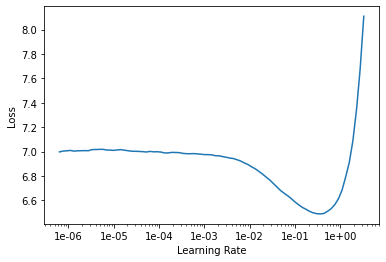

In [57]:
learn_bwd.recorder.plot()

In [58]:
bs=48
lr_bwd = 2e-02
# lr_bwd *= bs/20

In [60]:
learn_bwd.fit_one_cycle(1, lr_bwd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.325920,4.629201,0.243204,00:26


In [61]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(1, lr_bwd/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.746543,4.381660,0.282788,00:32


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.

In [62]:
learn_bwd.save('fine_tuned_bwd')
learn_bwd.save_encoder('fine_tuned_enc_bwd')

In [63]:
test_df=df[16934:].copy()
train_df=df[:16934].copy()
len(test_df),len(train_df)

(1882, 16934)

In [64]:
data_clas_bwd = (TextList.from_df(train_df, cols=['instance'], vocab=data_lm_bwd.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df(cols= 'label exp 2')
             .databunch(bs=48,backwards=True))

data_clas_bwd.show_batch()

text,target
methods modern xxunk be not can that one and floor sound firm xxbos,0.0
about be might she what at afraid almost xxunk half question xxbos,0.0
street mount and row park between orchard large a was there xxbos,1.0
nice a and food good with pub country traditional a is xxbos,1.0
plants of diversity rich a for habitat important provides west the xxbos,1.0


In [65]:
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=1.0,metrics=[accuracy]).to_fp16()
learn_c_bwd.load_encoder('fine_tuned_enc_bwd')
learn_c_bwd.freeze()

In [66]:
learn_c_bwd.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


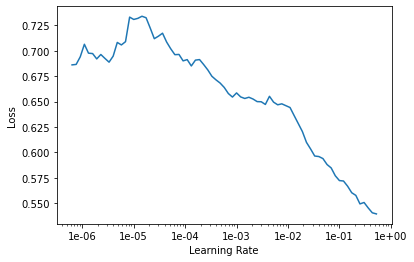

In [67]:
learn_c_bwd.recorder.plot()

In [68]:
bs=48
lr_bwd = 1e-02
lr_bwd *= bs/20

In [69]:
learn_c_bwd.fit_one_cycle(1,lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.199052,0.153910,0.561725,00:11


In [71]:
learn_c_bwd.unfreeze()
learn_c_bwd.fit_one_cycle(1, slice(lr_bwd/2,lr_bwd), moms=(0.5,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.162550,0.143528,0.561725,00:37


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:1319: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if p.

In [72]:
learn_c_bwd.save('learner_bwd')

In [73]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs)

tensor(0.5588)

In [74]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b)

tensor(0.5617)

In [75]:
preds_avg = (preds+preds_b)/2

In [76]:
# average accuracy 
accuracy(preds_avg,targs_b)

tensor(0.5617)

In [79]:
y_true=test_df['label exp 2']

In [ ]:
forward_prob=[]
for i in range(len(test_df)):
  p=learn_c.predict(test_df.iloc[i])
  forward_prob.append(float((p[0]).data[0]))


In [82]:
bwd_prob=[]
for i in range(len(test_df)):
  p=learn_c_bwd.predict(test_df.iloc[i])
  bwd_prob.append(float((p[0]).data[0]))

In [83]:

y_pred=[]
for i in range(len(my)):
  if (float((forward_prob[i]+bwd_prob[i])/2))>0.5:
    y_pred.append(1.0)
  else:
    y_pred.append(0.0)

In [ ]:
final_my= np.nan_to_num(final_my, copy=True)
pred= np.nan_to_num(pred, copy=True)

In [88]:
import sklearn
print(sklearn.metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.81      0.77       800
         1.0       0.85      0.77      0.81      1082

    accuracy                           0.79      1882
   macro avg       0.79      0.79      0.79      1882
weighted avg       0.79      0.79      0.79      1882

